I anecdotally observe that the 30GeV LJ pT requirement is cutting more LJs than I expected. The SIDM AN claims that the 30GeV LJ pT cut is reasonable because 92% of dark photons from 100GeV bound states have pT > 30 GeV. This notebook investigates that claim.

First, take a look at LJ properties in arbitrary 2mu2e 100 GeV bound state sample

In [1]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea.nanoevents import NanoEventsFactory
#plotting
import matplotlib.pyplot as plt
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from analysis.tools import ffschema, sidm_processor
# always reload local modules to pick up changes during development
importlib.reload(ffschema)
importlib.reload(sidm_processor)

<module 'analysis.tools.sidm_processor' from '/home/cms-jovyan/SIDM/analysis/studies/../../analysis/tools/sidm_processor.py'>

In [2]:
sample_dir = "root://xcache//store/group/lpcmetx/SIDM/ffNtupleV4/2018/"
sample_name = "SIDM_XXTo2ATo2Mu2E_mXX-100_mA-1p2_ctau-9p6"
sample_file = f"{sample_dir}/{sample_name}_TuneCP5_13TeV-madgraph-pythia8/RunIIAutumn18DRPremix-102X_upgrade2018_realistic_v15-v1/210326_161703/0000/ffNtuple_1.root"

events = NanoEventsFactory.from_root(
    sample_file,
    treepath='ffNtuplizer/ffNtuple',
    schemaclass=ffschema.FFSchema,
    metadata = {
        "dataset" : sample_name, 
    },
).events()

Run 4mu and 2mu2e channels w/ and w/o the LJ pT cut applied

In [3]:
importlib.reload(sidm_processor)
p = sidm_processor.SidmProcessor(
    [
        "4mu_noLjPtCut",
        "2mu2e_noLjPtCut",
        "4mu",
        "2mu2e",
    ],
    ["base"]
)
out = p.process(events)

Take a look at cutflows

In [4]:
for channel, cutflow in out[sample_name]["cutflow"].items():
    print(channel)
    cutflow.print_table(fraction=True)
    print()

4mu_noLjPtCut
cut name        individual %    marginal %    cumulative %
------------  --------------  ------------  --------------
No selection           100.0         100.0           100.0
PV filter              100.0         100.0           100.0
Cosmic veto            100.0         100.0           100.0
>=2 LJs                 80.6          80.6            80.6
4mu                     54.6          67.7            54.6

2mu2e_noLjPtCut
cut name        individual %    marginal %    cumulative %
------------  --------------  ------------  --------------
No selection           100.0         100.0           100.0
PV filter              100.0         100.0           100.0
Cosmic veto            100.0         100.0           100.0
>=2 LJs                 80.6          80.6            80.6
2mu2e                   25.9          32.2            25.9

4mu
cut name        individual %    marginal %    cumulative %
------------  --------------  ------------  --------------
No selection        

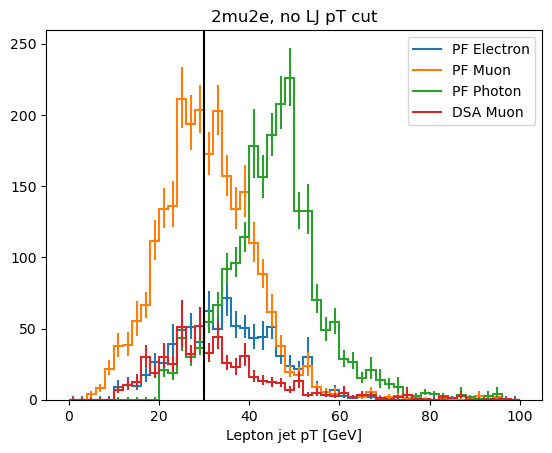

/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


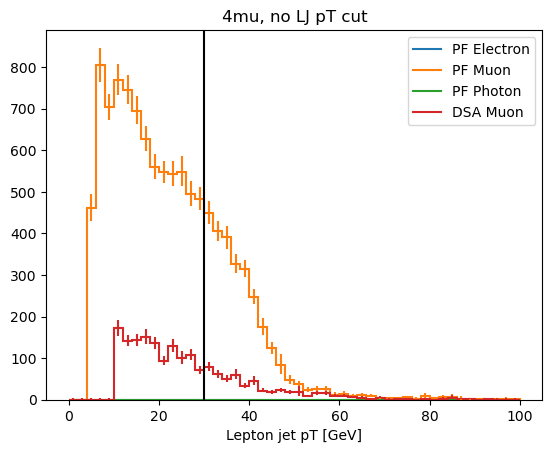

In [5]:
lj_type_names = {
    2: "PF Electron",
    3: "PF Muon",
    4: "PF Photon",
    8: "DSA Muon",
}
out[sample_name]["hists"]["lj_pt_type"]["2mu2e_noLjPtCut", ::2j, :].stack("lj_type").plot()
plt.title("2mu2e, no LJ pT cut")
plt.legend(lj_type_names.values())
plt.axvline(x=30, color="black")
plt.show()

out[sample_name]["hists"]["lj_pt_type"]["4mu_noLjPtCut", ::2j, :].stack("lj_type").plot()
plt.title("4mu, no LJ pT cut")
plt.legend(lj_type_names.values())
plt.axvline(x=30, color="black")
plt.show()


As foreshadowed by the cutflows, LJs w/ pT<30GeV are primarily mu-type. The 4mu events are generally dominated by low-pT LJs. I expect these are mostly bg LJs (it's also not yet clear to me that the muon number and charge LJ criteria are already applied in the ntuples). Take a look at LJ-LJ dPhi and the reco bound state mass, i.e. invmass(LJ, LJ), to help understand what fraction the leading two LJs in an event are actually the result of dark photons.

(2.0, 20000.0)

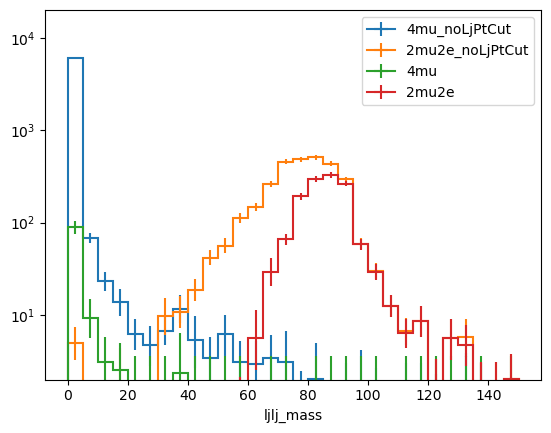

In [6]:
out[sample_name]["hists"]["lj_lj_invmass_lowRange"][:, :150j].plot1d()
plt.legend()
plt.yscale("symlog")
plt.ylim([2, 20000])

(2.0, 20000.0)

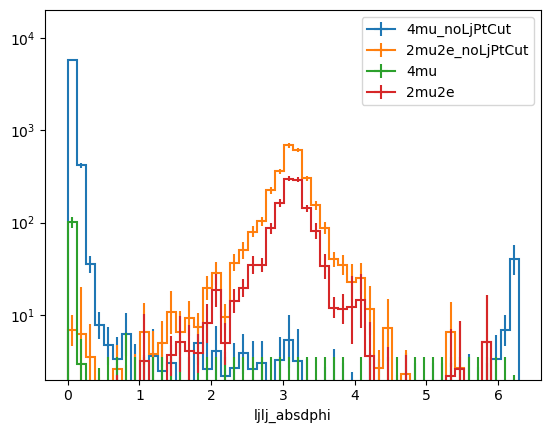

In [7]:
out[sample_name]["hists"]["lj_lj_absdphi"].plot1d()
plt.legend()
plt.yscale("symlog")
plt.ylim([2, 20000])

With or without a LJ pT cut, the leading two LJs in 4mu-channel evts effectively never successfully reconstruct the bound state mass and are almost always very close together in phi, both of which seem like very reasonable results for a 2mu2e sample. The leading two LJs in 2mu2e-channel evts, on the other hand, generally more or less reconstruct the bound state mass and are almost always back to back.

The reconstructed bound state mass appears to be systematically lower than the true bound state mass, and this effect is more pronounced when the LJ pT cut is removed. Other than the addition of a small peak at small dPhi, the LJ pT cut appears to have almost no effect on the probability that the leading two LJs in a 2mu2e event are back to back.

Following the results in `exlore_genParticles`, I will now take a look at these same quantities after requiring that all LJs are near a dark photon (`dR(LJ, genA) < 0.2`) and all events contain at least 2 dark photons that are near a LJ (dR<0.2 again)

In [8]:
channels =  [
    "4mu_matchedLj_noLjPtCut",
    "2mu2e_matchedLj_noLjPtCut",
    "4mu_matchedLj",
    "2mu2e_matchedLj",
]
hists =  ["base_plus_gen"]
importlib.reload(sidm_processor)
p = sidm_processor.SidmProcessor(channels, hists)
out_matchedLj = p.process(events)

In [9]:
for channel, cutflow in out_matchedLj[sample_name]["cutflow"].items():
    print(channel)
    cutflow.print_table(fraction=True)
    print()

4mu_matchedLj_noLjPtCut
cut name          individual %    marginal %    cumulative %
--------------  --------------  ------------  --------------
No selection             100.0         100.0           100.0
PV filter                100.0         100.0           100.0
Cosmic veto              100.0         100.0           100.0
>=2 LJs                   79.5          79.5            79.5
>=2 matched As            28.3          32.5            25.8
4mu                       53.6           0.2             0.1

2mu2e_matchedLj_noLjPtCut
cut name          individual %    marginal %    cumulative %
--------------  --------------  ------------  --------------
No selection             100.0         100.0           100.0
PV filter                100.0         100.0           100.0
Cosmic veto              100.0         100.0           100.0
>=2 LJs                   79.5          79.5            79.5
>=2 matched As            28.3          32.5            25.8
2mu2e                     25.8    

/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


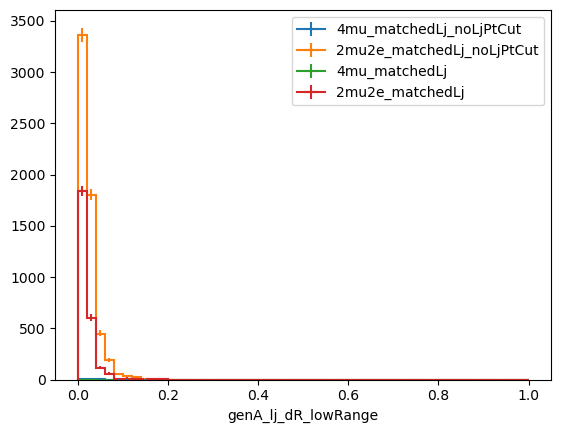

In [10]:
out_matchedLj[sample_name]["hists"]["genA_lj_dR_lowRange"].plot()
plt.legend()
#plt.yscale("symlog")

ok, this kills off basically all the 4mu events (w/ or w/o the pT cut), but the difference in the 2mu2e efficiencies w/ and w/o the pT cut remains.

I had to do the matching as an event-level cut so only selected LJs are considered as candiates for matching. Appears to work well. Take a look at some LJ properties after matching:

/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


(2.0, 20000.0)

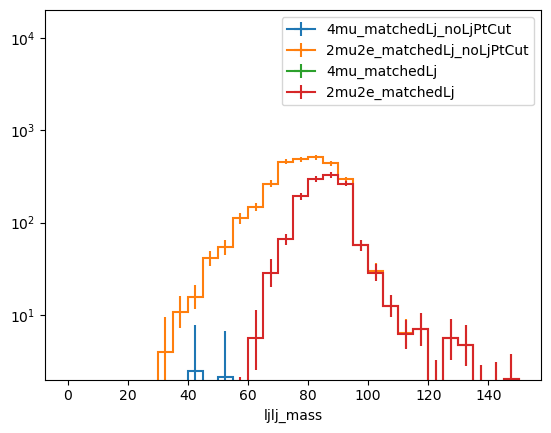

In [11]:
out_matchedLj[sample_name]["hists"]["lj_lj_invmass_lowRange"][:, :150j].plot1d()
plt.legend()
plt.yscale("symlog")
plt.ylim([2, 20000])

/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


(2.0, 20000.0)

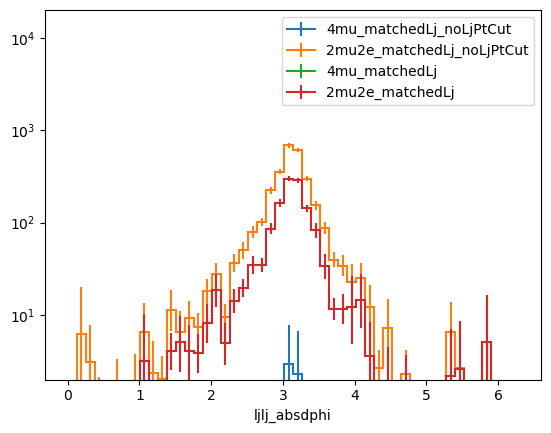

In [12]:
out_matchedLj[sample_name]["hists"]["lj_lj_absdphi"].plot1d()
plt.legend()
plt.yscale("symlog")
plt.ylim([2, 20000])

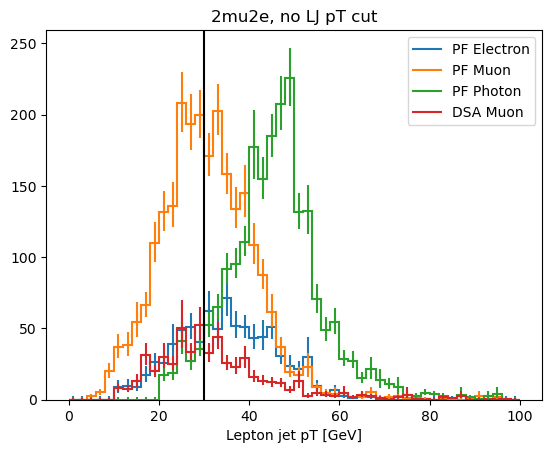

In [13]:
out_matchedLj[sample_name]["hists"]["lj_pt_type"]["2mu2e_matchedLj_noLjPtCut", ::2j, :].stack("lj_type").plot()
plt.title("2mu2e, no LJ pT cut")
plt.legend(lj_type_names.values())
plt.axvline(x=30, color="black")
plt.show()

2mu2e-channel LJ properties are all basically unchanged after matching. It sure seems like the 30GeV cut is killing off a reasonable fraction of legit LJs (~50%?). The bound-state mass resolution looks a little worse with no pT cut, but not way worse. I'll plan to study resolution stuff more in a different notebook before proceeding here.